In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import pickle
from statistics import mean, stdev

In [ ]:
#Directory variables

PROTEIN_SCORE_DIR = 'verrou_all_results'
IEEE_DIR = 'IEEE'
IEEE_PROTEIN_SCORE_REF = 'ieee_ref.pkl'
INSTR_LIB = 'all'
THRESHOLD = 0.3

## Calculate protein stats

In [3]:
docker_pred = {}
for i in range(1,11):
    for j in range(0,646):
        f = open(PROTEIN_SCORE_DIR + '/%s_%s.pkl'%(i,j), 'rb')
        temp = pickle.load(f)
                
        pkl_dict = {}
        for prot in temp:
            pkl_dict[prot] = {}
            for go_id in temp[prot]:
                if temp[prot][go_id] >= 0.3:
                    pkl_dict[prot][go_id] = np.float64(temp[prot][go_id])
  
        for protein in pkl_dict.keys():
            if i == 1:
                docker_pred[protein] = {}
                for go_id in pkl_dict[protein]:
                    docker_pred[protein][go_id] = np.array([pkl_dict[protein][go_id]])
            else:

                for go_id in pkl_dict[protein]:
                    docker_pred[protein][go_id] = np.append(docker_pred[protein][go_id], pkl_dict[protein][go_id])

original_file = open(IEEE_DIR + IEEE_PROTEIN_SCORE_REF, 'rb')
pkl_dict = pickle.load(original_file)
original_results = {}

for protein in pkl_dict:
    original_results[protein] = pkl_dict[protein]


In [4]:
# protein stats
stats = {}
dfs = {}
proteins = []
for name in list(docker_pred.keys()):
    proteins.append(name)
#     print(name, len(docker_pred[name]))
    stats[name] = {'GO term':[], 'Standard deviation':[], 'Mean': [], 'Standard error': [], 'Original Result': []}
    for i in docker_pred[name].keys():
        stats[name]['GO term'] = np.append(stats[name]['GO term'], i)
        stats[name]['Standard deviation'] = np.append(stats[name]['Standard deviation'], np.std(docker_pred[name][i].astype(np.float64), dtype=np.float64))
        stats[name]['Mean'] = np.append(stats[name]['Mean'], np.mean(docker_pred[name][i].astype(np.float64), dtype=np.float64))
        stats[name]['Standard error'] = np.append(stats[name]['Standard error'], (np.std(docker_pred[name][i].astype(np.float64), dtype=np.float64) / np.sqrt(len(docker_pred[name][i])).astype(np.float64)))
        if i in original_results[name].keys():
            stats[name]['Original Result'] = np.append(stats[name]['Original Result'], original_results[name][i])
        
    dfs[name] = pd.DataFrame(stats[name])

### Metrics

In [9]:
#metric stats
metrics ={'bp': {'threshold':[], 'Smin':[], 'Fmax':[], 'AUPR':[]}, 'cc':{'threshold':[], 'Smin':[], 'Fmax':[], 'AUPR':[]}, 'mf':{'threshold':[], 'Smin':[], 'Fmax':[], 'AUPR':[]}}
metric_stats ={'bp': {'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}, 'cc':{'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}, 'mf':{'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}}
df_metric = {'bp':{}, 'cc':{}, 'mf':{}}

for category in ['bp', 'cc', 'mf']:
    for i in range(1,11): #

        metrics_file = open(PROTEIN_SCORE_DIR + "/%s_%s.txt"%(category, i))
        read_file = csv.reader(metrics_file)
        next(read_file)

        for row in read_file: 
#             if 'Smin threshold' in row[0] or 'Precision' in row[0] or 'Recall' in row[0] or 'Positive' in row[0] or 'Negative' in row[0]: continue
            if 'Length' in row[0]: continue
            metric, score = row[0].split(': ')
            metrics[category][metric].append(np.float64(score))
    
    metrics_file = csv.reader(open(IEEE_DIR + "/%s.txt"%category))
    next(metrics_file)
    for row in metrics_file:
#         if 'Smin threshold' in row[0] or 'Precision' in row[0] or 'Recall' in row[0] or 'Positive' in row[0] or 'Negative' in row[0]: continue
        if 'Length' in row[0]: continue
        term, score = row[0].split(': ')
        metric_stats[category][term]['Original Result'] = [np.float64(score)]

    for i in metrics[category]: 
        metric_stats[category][i]['Standard Deviation'] = [stdev(metrics[category][i])]
        metric_stats[category][i]['Mean'] = [mean(metrics[category][i])]
        metric_stats[category][i]['Standard Error'] = [stdev(metrics[category][i]) / np.sqrt(len(metrics[category][i]), dtype=np.float64)]

        df_metric[category]['%s'%i] = pd.DataFrame(metric_stats[category][i])

## Significant Digits

In [11]:
count = 0
sig_file = open('References/sig_proteins_%s.txt'%INSTR_LIB)
protein_sig = {}
for row in sig_file:
    if 'NEW PROTEIN' in row:
        p_name = proteins[count]
        protein_sig[p_name] = {}
        count += 1
        continue
        
    if len(row.split(',')) == 1:
        name = row[:-2]

    else:
        if 'Relative' not in name and 'CNH' not in name:
            scores = row.split(',')[:-1]
            protein_sig[p_name][name + ' Mean'] = np.mean(np.array(scores).astype(float))
            protein_sig[p_name][name + ' Standard Deviation'] = np.std(np.array(scores).astype(float))
            
protein_sig = pd.DataFrame(protein_sig).T

In [12]:
sig_metrics = {'bp': {'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}, 'cc':{'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}, 'mf':{'threshold':{}, 'Smin':{}, 'Fmax':{}, 'AUPR':{}}}

for category in ['bp', 'cc', 'mf']:
    sig_file = open('References/sig_%s_%s.txt'%(category, INSTR_LIB))

    for row in sig_file:
        if len(row.split(',')) == 1:
            name = row[:-1]
        else:
            if 'Relative' not in name and 'CNH' not in name:
                scores = row.split(',')
                sig_metrics[category]['threshold'][name] = scores[0]
                sig_metrics[category]['Smin'][name] = scores[1]
                sig_metrics[category]['Fmax'][name] = scores[2]
                sig_metrics[category]['AUPR'][name] = scores[3]

for category in ['bp', 'cc', 'mf']:
    for metric in sig_metrics[category]:
        for column in sig_metrics[category][metric]:
#             print(column)
            df_metric[category][metric][column] = sig_metrics[category][metric][column]

## Results

#### Significant Digits of Test Proteins

In [13]:
protein_sig.describe()

,[General] Absolute significant Mean,[General] Absolute significant Standard Deviation,[General] Absolute contributing Mean,[General] Absolute contributing Standard Deviation
count,3874.000000,3874.000000,3874.000000,3874.000000
mean,6.790122,0.156376,6.797097,0.171162
std,0.145018,0.128039,0.145653,0.135745
min,2.665878,0.000000,2.446208,0.000000
25%,6.761597,0.132558,6.773175,0.138693
50%,6.809155,0.147474,6.812784,0.159314
75%,6.845676,0.169167,6.844471,0.188121
max,6.923690,2.826399,6.923690,2.976401


#### Stats on Protein Metrics for 3 Principal Protein Ontology Classes

In [14]:
df_mf = df_metric['mf']['Smin'].append(df_metric['mf']['Fmax']).append(df_metric['mf']['AUPR']).append(df_metric['mf']['threshold']).set_index([pd.Index(['Smin', 'Fmax', 'AUPR', 'Fmax threshold'])])
# with pd.option_context('display.precision', 20): display(df_bp)
df_mf

,Original Result,Standard Deviation,Mean,Standard Error,[General] Absolute significant:,[General] Absolute contributing:
Smin,9.597233,0.0,9.597233,0.0,6.923689900271567,6.923689900271567
Fmax,0.663958,0.0,0.663958,0.0,6.923689900271567,6.923689900271567
AUPR,0.670708,0.0,0.670708,0.0,6.923689900271567,6.923689900271567
Fmax threshold,0.180000,0.0,0.180000,0.0,6.923689900271567,6.923689900271567


In [15]:
df_cc = df_metric['cc']['Smin'].append(df_metric['cc']['Fmax']).append(df_metric['cc']['AUPR']).append(df_metric['cc']['threshold']).set_index([pd.Index(['Smin', 'Fmax', 'AUPR', 'Fmax threshold'])])
# with pd.option_context('display.precision', 20): display(df_bp)
df_cc

,Original Result,Standard Deviation,Mean,Standard Error,[General] Absolute significant:,[General] Absolute contributing:
Smin,10.448033,0.0,10.448033,0.0,6.923689900271567,6.923689900271567
Fmax,0.694438,0.0,0.694438,0.0,6.923689900271567,6.923689900271567
AUPR,0.737946,0.0,0.737946,0.0,6.923689900271567,6.923689900271567
Fmax threshold,0.240000,0.0,0.240000,0.0,6.923689900271567,6.923689900271567


In [16]:
df_bp = df_metric['bp']['Smin'].append(df_metric['bp']['Fmax']).append(df_metric['bp']['AUPR']).append(df_metric['bp']['threshold']).set_index([pd.Index(['Smin', 'Fmax', 'AUPR', 'Fmax threshold'])])
# with pd.option_context('display.precision', 20): display(df_bp)
df_bp

,Original Result,Standard Deviation,Mean,Standard Error,[General] Absolute significant:,[General] Absolute contributing:
Smin,44.377911,0.000000e+00,44.377911,0.000000e+00,6.923689900271567,6.923689900271567
Fmax,0.530160,0.000000e+00,0.530160,0.000000e+00,6.923689900271567,6.923689900271567
AUPR,0.495861,3.980676e-08,0.495861,1.258800e-08,6.923689900271567,6.923689900271567
Fmax threshold,0.210000,0.000000e+00,0.210000,0.000000e+00,6.923689900271567,6.923689900271567


#### Stats on Individual Protein Classes

In [17]:
max_val = []
for i in np.array(list(dfs.keys())):

    if len(dfs[i]['Standard deviation']) != 0:
        a = max(dfs[i]['Standard deviation'])
        max_val.append(a)

max(max_val)

7.205816996988545e-07

In [18]:
dfs['ACK1_YEAST'] 

,GO term,Standard deviation,Mean,Standard error,Original Result
0,GO:0005575,1.047754e-07,0.776371,3.313289e-08,0.776371
1,GO:0110165,1.047754e-07,0.776371,3.313289e-08,0.776371
2,GO:0003674,1.137184e-07,0.620349,3.596092e-08,0.620349
3,GO:0008150,9.253129e-08,0.933437,2.926096e-08,0.933437
4,GO:0043229,9.253129e-08,0.530498,2.926096e-08,0.530498
5,GO:0043231,6.529362e-08,0.410556,2.064765e-08,0.410556
6,GO:0016020,6.114925e-08,0.468064,1.933709e-08,0.468064
7,GO:0043227,8.429370e-08,0.421303,2.665601e-08,0.421303
8,GO:0005622,1.067905e-07,0.764394,3.377012e-08,0.764394
9,GO:0043226,9.253129e-08,0.530498,2.926096e-08,0.530498


## Graphics

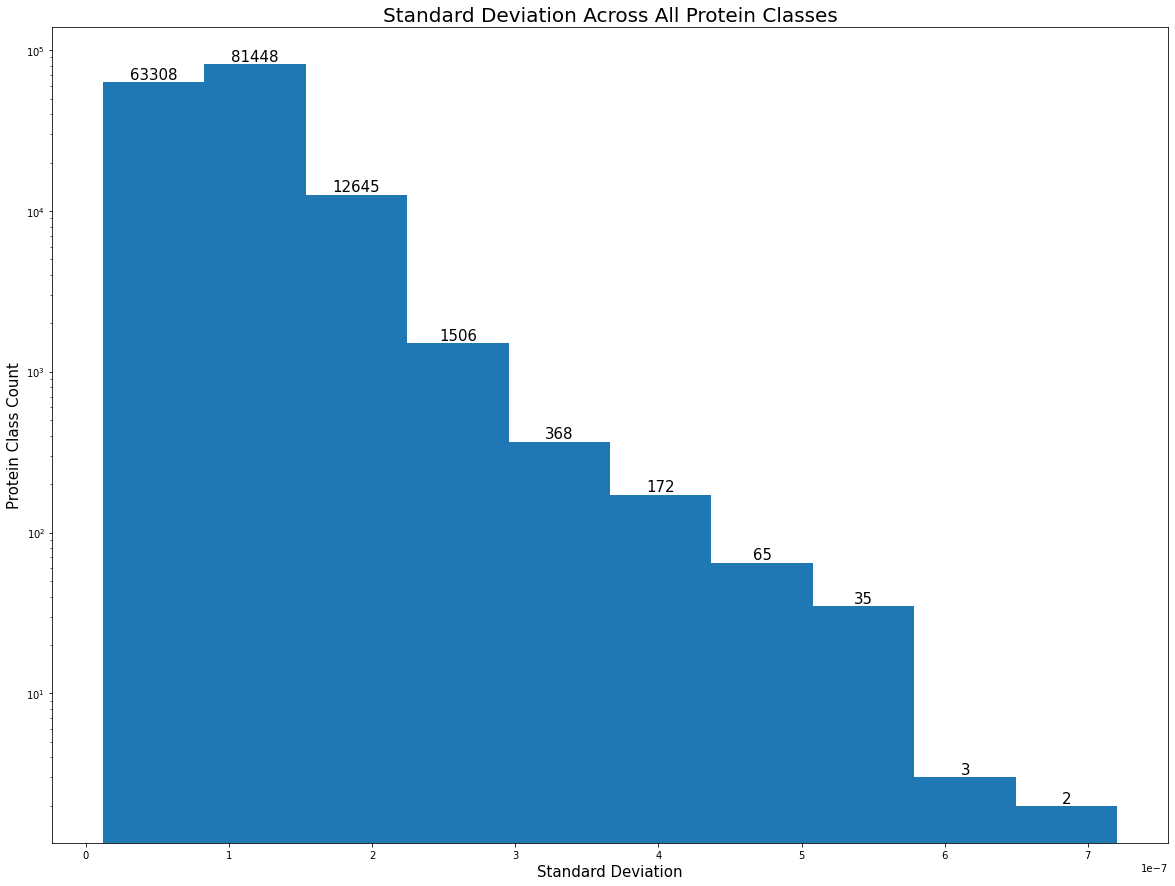

In [19]:
protein_class_std = []
for protein in dfs.values():
    for value in protein['Standard deviation']:
        protein_class_std.append(value)

plt.figure(figsize=(20,15))
_, _, bars = plt.hist(protein_class_std, bins=10)
plt.bar_label(bars, fontsize=15), plt.title('Standard Deviation Across All Protein Classes', fontsize=20)
plt.xlabel('Standard Deviation', fontsize=15), plt.ylabel('Protein Class Count', fontsize=15)
plt.yscale('log'); 